## Environment Setup

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import argparse

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [4]:
# Run on GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## Import/Modify VGG and Establish Feature Extraction

In [5]:
# Establish the model and features
def model_selection():
    # Import VGG-19 network
    vgg19 = models.vgg19(pretrained = True).features.to(device).eval()
    
    # Adjust modules
    for name, module in vgg19.named_modules():
        # Convert max pooling to average
        if isinstance(module, nn.MaxPool2d):
            vgg19[int(name)] = nn.AvgPool2d(kernel_size = 2, stride = 2)

    # Prevent gradient change
    for param in vgg19.parameters():
        param.requires_grad = False
    
    # Return modified vgg19
    return vgg19

In [6]:
# Obtain style and content features
def get_features(image, model, layers=None):
    # Set feature dictionary 
    features = {}
    x = image
    
    # Add outputs of layer if they are content or style layers
    for name, layer in enumerate(model):
        x = layer(x)
        if str(name) in layers:
            features[str(name)] = x
    
    # Return list of features
    return list(features.values())

### Style Loss - gram matrix

In [7]:
# Create gram matrix
def gram_matrix(tensor):
    # Obtain tensor dimensions (batch, channels, height, width)
    b, c, h, w = tensor.size()
    
    # Reshape the tensor to obtain feature space
    feature_space = tensor.view(b, c, h*w)
    
    # Compute gram matrix
    gram = torch.bmm(feature_space, torch.transpose(feature_space, 1, 2))
    
    # Return normalized gram matrix
    return gram.div_(h*w)

## Functions to Process and Save Images

In [8]:
# Load images
def load_images(style_name, content_name):
    style_img = Image.open('Style_Images/'+ style_name +'.jpg')
    content_img = Image.open('Content_Images/'+ content_name +'.jpg')
    
    return style_img, content_img

In [9]:
# Create function to convert the image to a tensor
def img_to_tensor(image, image_size = 512):
    # Create resize and tensor transformation 
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
    # Transform image
    tensor = transform(image)
    # Add batch dimension and return tensor
    return tensor.unsqueeze(0).to(device)

In [10]:
# Convert tensor to image to confirm resizing
def tensor_to_img(tensor):
    # Clone tensor
    tensor_clone = tensor.cpu().clone()
    # Remove batch dimension
    tensor_clone = tensor_clone.squeeze(0)
    # Convert to image
    image = transforms.ToPILImage()(tensor_clone)

    # Display image
    plt.imshow(image)

In [11]:
def save_nst_image(tensor, content_img = None, style_img = None):
    # Create filename
    filename = content_img + '_' + style_img + '.jpg'
    
    # Create directory for saving generated images using content image name
    directory = 'Generated_Images/' + content_img
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        pass
    
    # Save image and print confirmation
    save_image(tensor, os.path.join(directory, filename), normalize = True)
    print('Transferred Image Saved!')

## NST Setup

In [1]:
# Establish variables
iters = 25
alpha = 10
beta = 1e4
img_size = 512
model = model_selection()
content_img = 'mount_rushmore'
style_img = 'starry_night'
input_img = 'content'
content_layers = ['21']
style_layers = ['0','5','10','19','28']
#content_layers = ['22']
#style_layers = ['1','6','11','20','29']
style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

NameError: name 'model_selection' is not defined

In [31]:
loss_vals = [np.zeros(iters)]
loss_vals

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])]

In [32]:
'''
Run the Neural Style Transfer Algorithm using the following parameters:

INPUTS
iters: number of iterations using LBFGS loss 
alpha: content weight
beta: style weight
img_size: dimensions of resized images (set to 512x512)
content_img: image used to extract content features
style_img: image used to extract style features
input_img: designate input image as 'noise', 'content', or 'style'
content_layers: layers of network from which content features are extracted
style_layers: layers of network from which style features are extracted
style_weights: weights assigned to each style layer (default 0.2 for each)

OUTPUT

'''
def run_nst(iters = iters, alpha = alpha, beta = beta, img_size = img_size, model = model, 
            content_img = content_img, style_img = style_img, input_img = input_img,
            content_layers = content_layers, style_layers = style_layers, style_weights = style_weights):
    # Load images
    style, content = load_images(style_img, content_img)
    
    # Convert images to tensors
    style_tensor = img_to_tensor(style)
    content_tensor = img_to_tensor(content)
    
    # Obtain style representation 
    style_rep = get_features(style_tensor, model, style_layers)
    
    # Convert style features to gram matrices
    style_gram = [gram_matrix(style).detach() for style in style_rep]

    # Obtain content representation
    content_rep = get_features(content_tensor, model, content_layers)[0].detach()
    
    # Create input image tensor
    if input_img == 'content':
        noise = content_tensor.clone().requires_grad_().to(device)
    elif input_img == 'style':
        noise = style_tensor.clone().requires_grad_().to(device)
    else:
        noise = torch.randn(content_tensor.size(), requires_grad = True, device = device)
    
    # Set optimizer
    optimizer = optim.LBFGS([noise])
    
    # Run model
    for i in tqdm(range(iters)):

        def closure():
            # Zero the gradient
            optimizer.zero_grad()

            # Initialize content and style loss
            content_loss = 0
            style_loss = 0

            # Calculute content features of noise
            noise_content = get_features(noise, model, content_layers)[0]

            # Calculate content loss
            content_loss = nn.MSELoss()(noise_content, content_rep)

            # Calculate style features of noise
            noise_style = get_features(noise, model, style_layers)

            # Convert style features to gram matrices
            noise_gram = [gram_matrix(style) for style in noise_style]

            # Calculate loss for each gram matrix
            for j in range(len(noise_gram)):
                style_loss += nn.MSELoss()(noise_gram[j], style_gram[j])*style_weights[j]

            # Calculate total loss
            total_loss = alpha*content_loss + beta*style_loss 
            total_loss.backward()

            # Backpropagate
            return total_loss

        # Update
        optimizer.step(closure)
        #loss_vals[i] = closure()
    
    return noise

## Run NST

In [33]:
# Run NST algorithm
transfer = run_nst()
# Save the image
save_nst_image(transfer, content_img = content_img, style_img = style_img)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:07<00:00,  5.10s/it]

Transferred Image Saved!


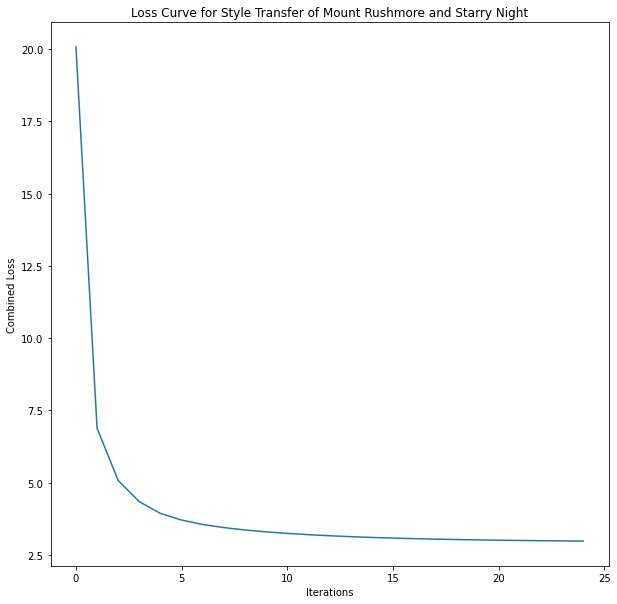

In [31]:
plt.figure(figsize = (10,10))
plt.plot(range(iters), loss_vals)
plt.xlabel('Iterations')
plt.ylabel('Combined Loss')
plt.title('Loss Curve for Style Transfer of Mount Rushmore and Starry Night')
plt.show()